In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/Dataset-06.csv')
df.head()

<ipython-input-4-126786d5e6cc>:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Dataset-06.csv')


,date,lat,lon,smajax,sminax,strike,q,depth,unc,q.1,...,mtp,mtt,str1,dip1,rake1,str2,dip2,rake2,type,eventid
0,1904-04-04 10:02:34.56,41.802,23.108,8.6,6.6,164.2,B,15.0,4.8,C,...,,,,,,,,,,610326271
1,1904-04-04 10:26:00.88,41.758,23.249,8.3,6.9,15.2,B,15.0,4.8,C,...,,,,,,,,,,16957813
2,1904-06-25 14:45:39.14,51.424,161.638,33.6,18.7,116.2,C,15.0,25.0,C,...,,,,,,,,,,16957820
3,1904-06-25 21:00:38.72,52.763,160.277,28.6,14.6,43.1,C,30.0,10.3,C,...,,,,,,,,,,16957819
4,1904-08-30 11:43:20.85,30.684,100.608,16.9,14.4,118.4,C,15.0,25.0,C,...,,,,,,,,,,16957826


In [ ]:
len(df)

70881

In [ ]:
locations = []
for i in range(len(df)):
  locations.append((df['lat'][i], df['lon'][i]))

In [ ]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lon for lat, lon in locations],
                                                    [lat for lat, lon in locations]))
gdf.head()

,geometry
0,POINT (23.108 41.802)
1,POINT (23.249 41.758)
2,POINT (161.638 51.424)
3,POINT (160.277 52.763)
4,POINT (100.608 30.684)


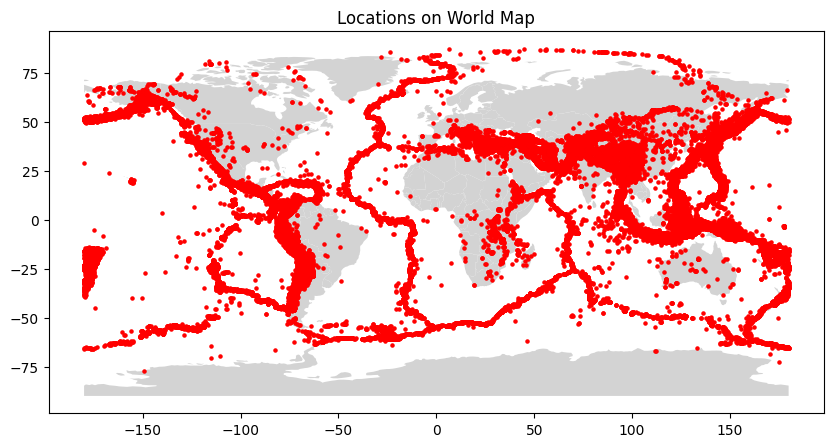

In [ ]:
world = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')

gdf.plot(ax=ax, color='red', markersize=5)

plt.title("Locations on World Map")
plt.show()

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

##DBScan
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points based on density. It works well when clusters have different shapes, but it struggles when densities vary too much. The main challenge is choosing eps—too small and you get too many noise points, too large and clusters merge incorrectly.


In [ ]:
for i in range(len(locations)):
  locations[i] = locations[i] + (df['depth'][i],)

locations = np.array(locations)
print(locations)

[[ 41.802  23.108  15.   ]
 [ 41.758  23.249  15.   ]
 [ 51.424 161.638  15.   ]
 ...
 [ -8.733 122.233 130.8  ]
 [ -0.793 146.809  14.4  ]
 [ -9.127 119.007  97.6  ]]


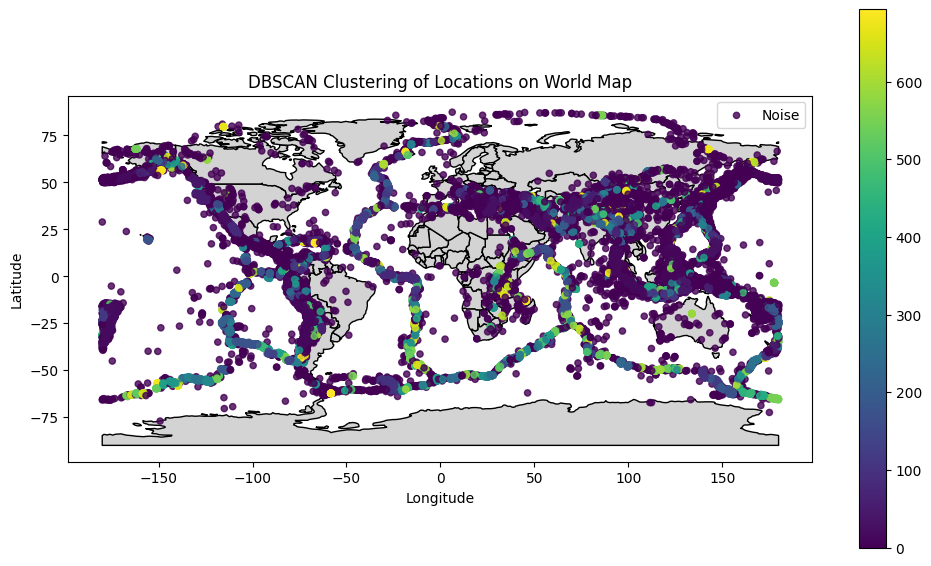

In [ ]:
locations = np.array(locations)

scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

eps = 0.5
min_samples = 7
db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(locations)

labels = db.labels_
unique_labels = set(labels)

gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),
    data={"Cluster": labels}
)

fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

gdf.plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True, alpha=0.8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Locations on World Map")
plt.legend(["Noise", "Clusters"])
plt.show()

### Performance Metrics
We used Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Score to evaluate clustering quality. Silhouette measures how well-separated clusters are, DB Index checks how compact they are, and CH Score favors distinct, well-spread clusters.


0.5
3 4 5 6 7 0.7
3 4 5 6 7 0.9
3 4 5 6 7 1.1
3 4 5 6 7 1.3
3 4 5 6 7 1.5
3 4 5 6 7 

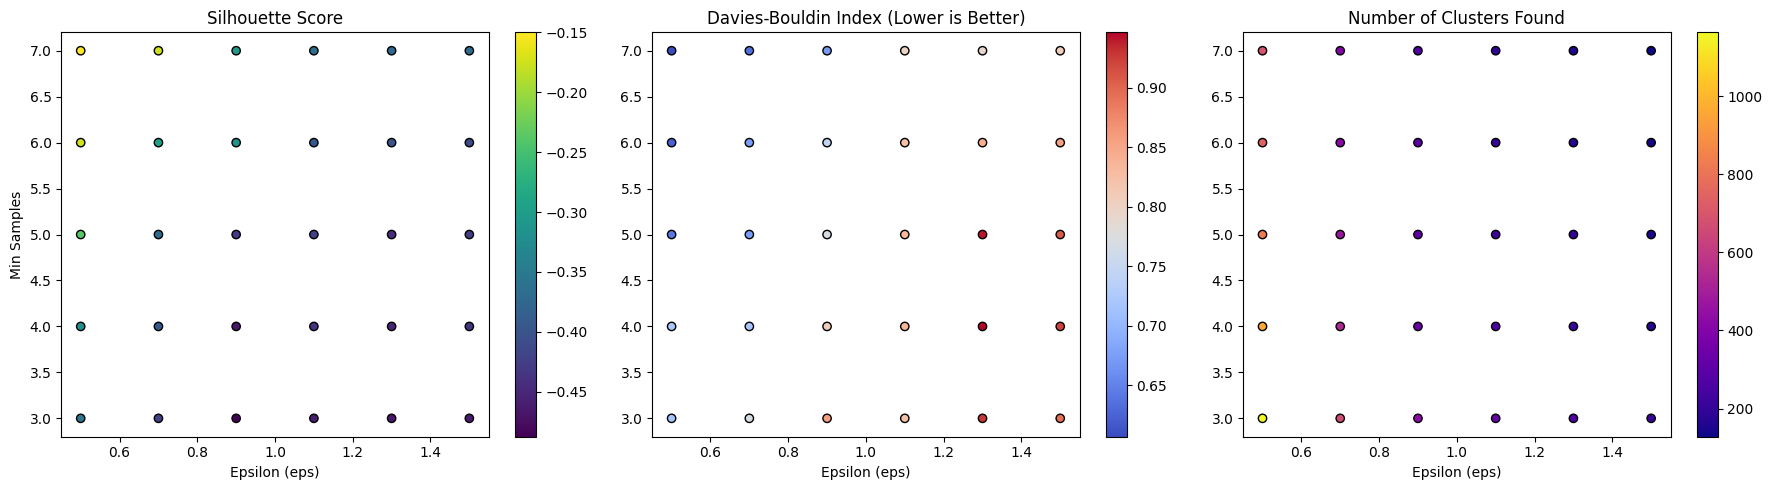

In [ ]:
scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

eps_values = np.linspace(0.5, 1.5, 6)
min_samples_values = range(3, 8)

results = []

for eps in eps_values:
    print(eps)
    for min_samples in min_samples_values:
        print(min_samples, end = " ")

        db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(locations)
        labels = db.labels_

        core_samples = locations[labels != -1]
        core_labels = labels[labels != -1]

        if len(set(core_labels)) > 1:
            silhouette = silhouette_score(core_samples, core_labels)
            db_index = davies_bouldin_score(core_samples, core_labels)
            ch_score = calinski_harabasz_score(core_samples, core_labels)
        else:
            silhouette, db_index, ch_score = None, None, None

        results.append((eps, min_samples, silhouette, db_index, ch_score, len(set(core_labels))))

results = np.array(results, dtype=object)

eps_grid = results[:, 0].astype(float)
min_samples_grid = results[:, 1].astype(int)
sil_scores = np.array([x if x is not None else 0 for x in results[:, 2]])
db_scores = np.array([x if x is not None else np.nan for x in results[:, 3]])
ch_scores = np.array([x if x is not None else 0 for x in results[:, 4]])
num_clusters = results[:, 5].astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc = axes[0].scatter(eps_grid, min_samples_grid, c=sil_scores, cmap="viridis", edgecolors="k")
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("Epsilon (eps)")
axes[0].set_ylabel("Min Samples")
fig.colorbar(sc, ax=axes[0])

sc = axes[1].scatter(eps_grid, min_samples_grid, c=db_scores, cmap="coolwarm", edgecolors="k")
axes[1].set_title("Davies-Bouldin Index (Lower is Better)")
axes[1].set_xlabel("Epsilon (eps)")
fig.colorbar(sc, ax=axes[1])

sc = axes[2].scatter(eps_grid, min_samples_grid, c=num_clusters, cmap="plasma", edgecolors="k")
axes[2].set_title("Number of Clusters Found")
axes[2].set_xlabel("Epsilon (eps)")
fig.colorbar(sc, ax=axes[2])

plt.tight_layout()
plt.show()

In [ ]:
# Filter out None values from Silhouette Scores
valid_results = results[~np.isnan(sil_scores)]

if valid_results.size > 0:
    # Get the index of the best Silhouette Score
    best_idx = np.argmax(sil_scores)

    # Extract the best parameters
    best_eps = results[best_idx, 0]
    best_min_samples = results[best_idx, 1]
    best_silhouette_score = results[best_idx, 2]

    print(f"Best Hyperparameters Found:")
    print(f"   - Epsilon (eps): {best_eps}")
    print(f"   - Min Samples: {best_min_samples}")
    print(f"   - Best Silhouette Score: {best_silhouette_score:.4f}")


Best Hyperparameters Found:
   - Epsilon (eps): 0.5
   - Min Samples: 7
   - Best Silhouette Score: -0.1499


A negative Silhouette Score means points are closer to other clusters than their own. This happens when clusters overlap or when too many points are marked as noise, making the remaining clusters poorly defined.

# Overall Conclusion
1.   Density-based methods work well for spatial data like earthquakes but struggle when density varies too much or data is too sparse.
2. For large datasets (70,000+ points), model-based clustering like Gaussian Mixture Models (GMM) or hierarchical clustering might perform better.
3. When we limit the number of points, we seemingly get better results in these density based functions.


# Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

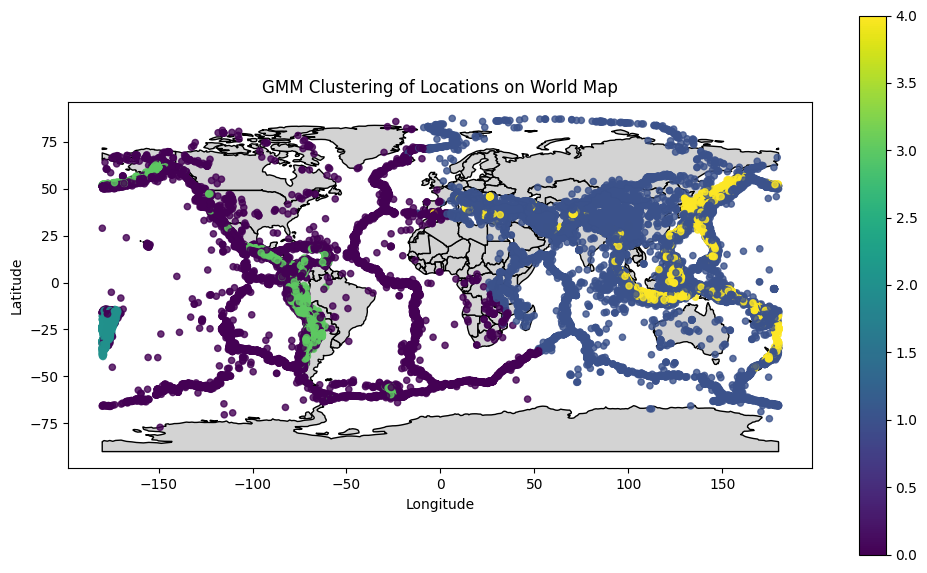

In [25]:
locations = np.array(locations)

scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

n_components = 5
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(locations)

labels = gmm.predict(locations)

gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),  # Longitude, Latitude
    data={"Cluster": labels}
)

fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

gdf.plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True, alpha=0.8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GMM Clustering of Locations on World Map")
plt.show()

3 4 5 6 7 8 9 10 

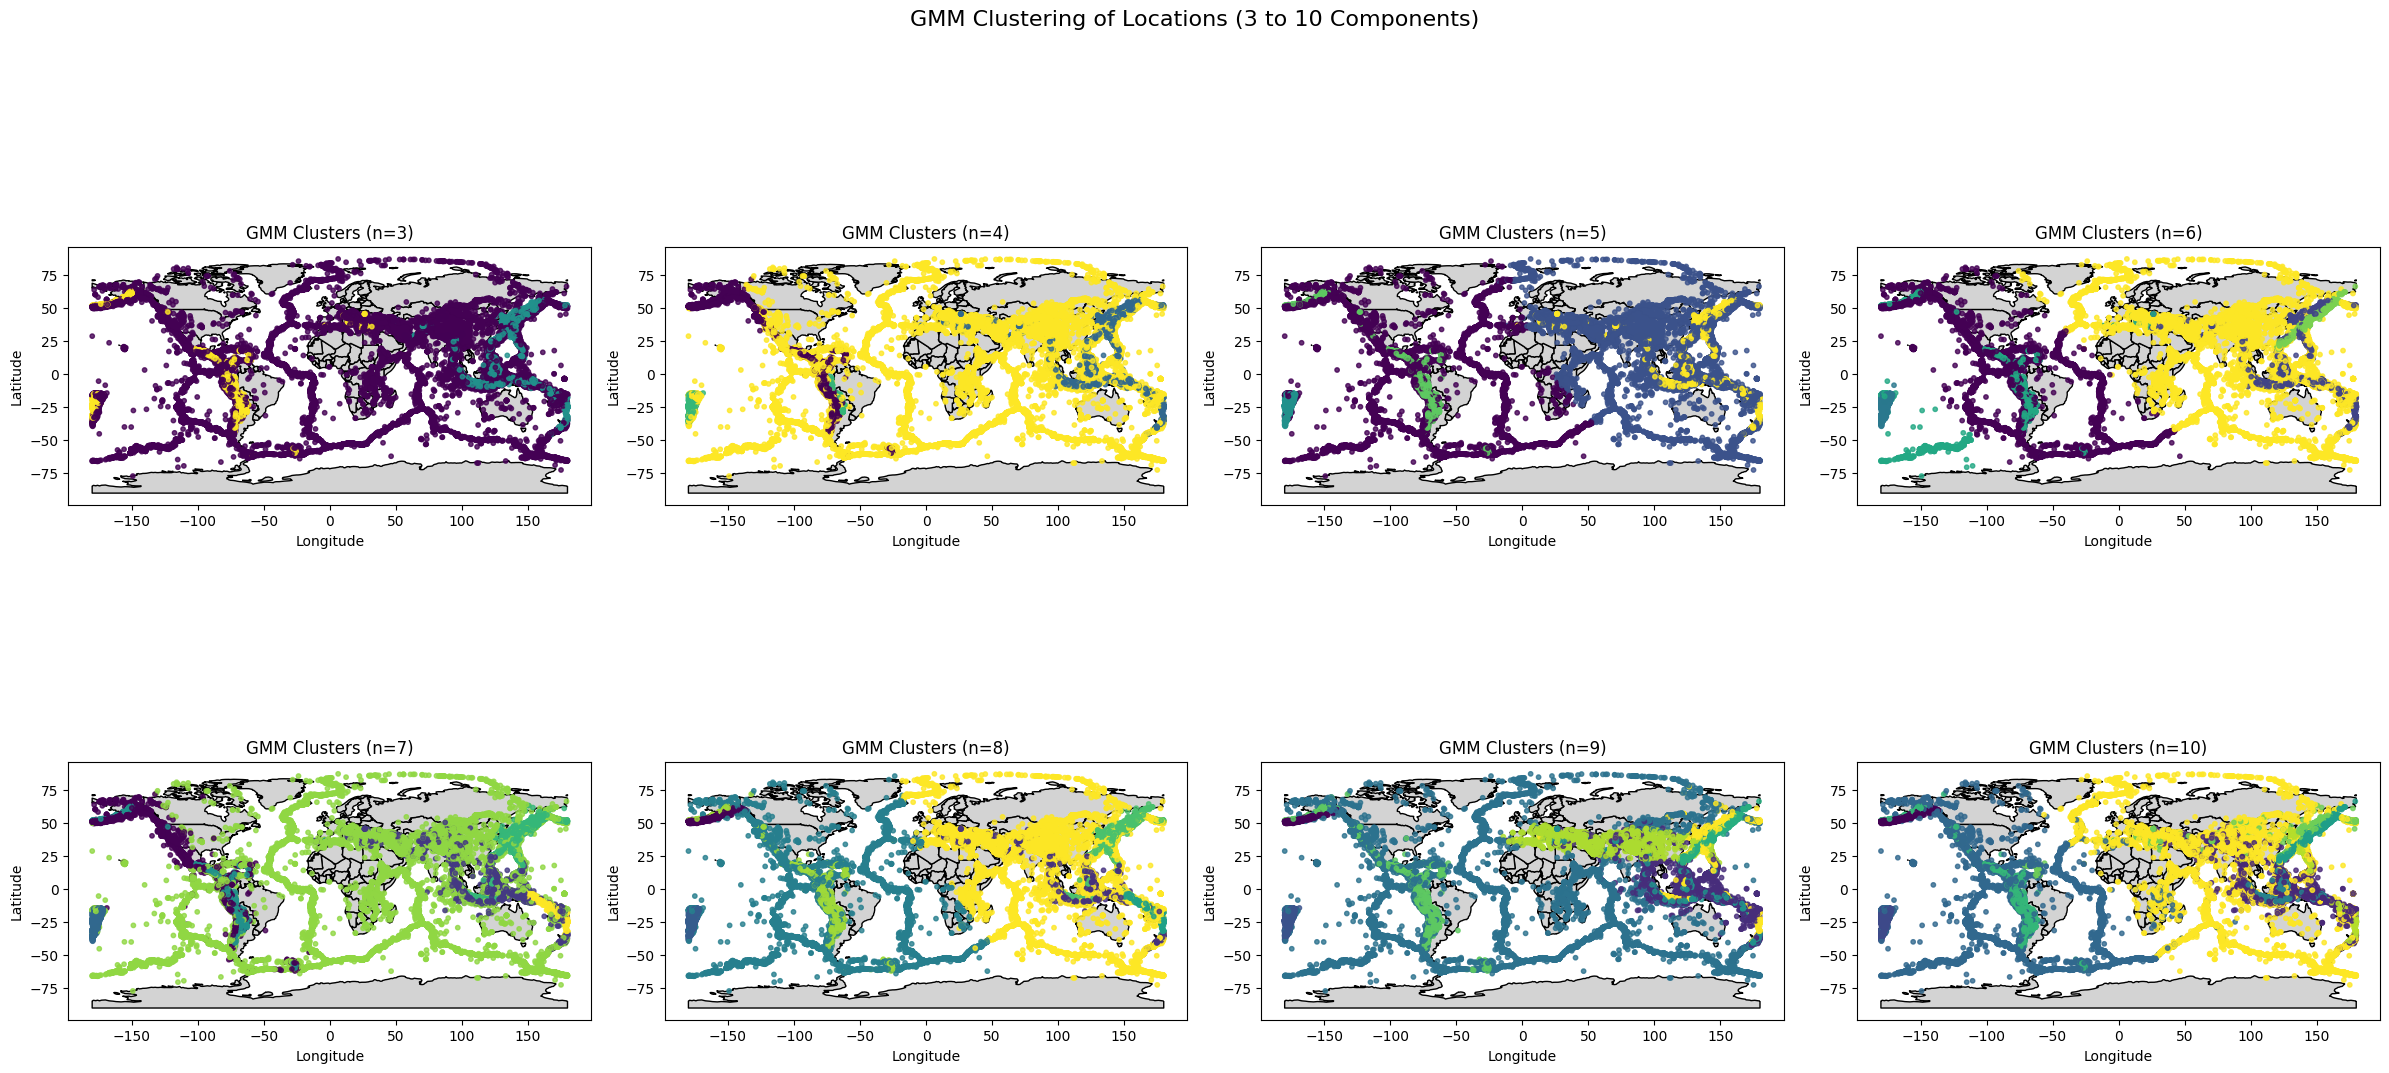

In [23]:
locations = np.array(locations)

scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for idx, n_components in enumerate(range(3, 11)):
    print(n_components, end = " ")
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(locations)
    labels = gmm.predict(locations)

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),
        data={"Cluster": labels}
    )

    ax = axes[idx]
    world.plot(ax=ax, color="lightgray", edgecolor="black")
    gdf.plot(ax=ax, column="Cluster", cmap="viridis", markersize=10, legend=False, alpha=0.8)
    ax.set_title(f"GMM Clusters (n={n_components})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.suptitle("GMM Clustering of Locations (3 to 10 Components)", fontsize=16, y=1.02)
plt.show()

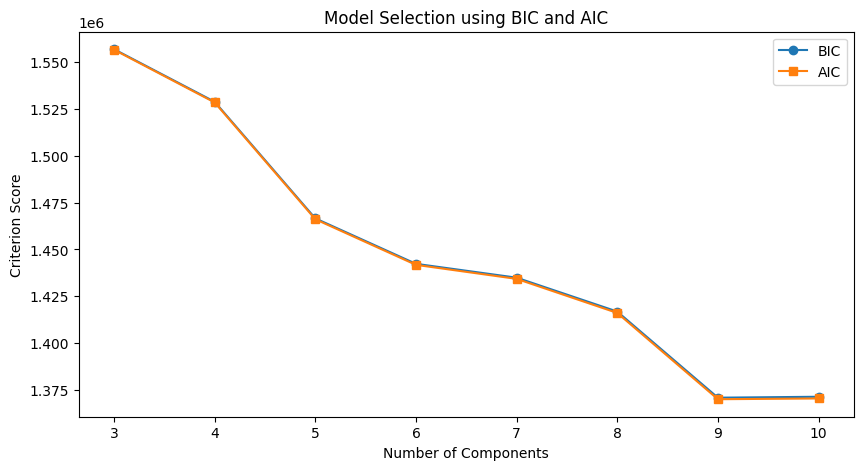

In [26]:
locations = np.array(locations)

scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

bic_scores = []
aic_scores = []
components_range = range(3, 11)

for n_components in components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(locations)
    bic_scores.append(gmm.bic(locations))
    aic_scores.append(gmm.aic(locations))

plt.figure(figsize=(10, 5))
plt.plot(components_range, bic_scores, marker='o', label='BIC')
plt.plot(components_range, aic_scores, marker='s', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Criterion Score')
plt.title('Model Selection using BIC and AIC')
plt.legend()

# Overall Conclusions

1. GMM performed well for large datasets by modeling elliptical clusters.

2. Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) were used to determine the optimal cluster number, minimizing overfitting.

3. The BIC gradient method provided a refined estimate of the optimal cluster count.